<h1>Siamese Network using Triplets in PyTorch</h1>

This notebook show how to build and train a Siamese Network to check similarities between image classes.
This is based on a real project I did where I have only 50 pictures of 2 different classes.

With so little pictures it is hard to build a classifier that is robust.
So, the trick is to use a Siamese Network not to classify the pictures in one or another class, but to
check how similar two pictures are. If they are from same class, we expect high similarity otherwise low similarity.
To perform this I used the triplet loss, which is composed by three images:
- Anchor image
- Positive image, with the same class as the Anchor (but not the same image)
- Negative image, with a different class from the previous two.
This way the aim of the network is to project embeedings, and when the images are from the same class, the embeedings must be
nearby each other, and when the images are from different class the embeedings are projected far from each other.
How far/near the embeedings are projected is defined by the margin hyperparameter.

To show this in practice, we'll use a real dataset of cats and dogs. What I mean by real dataset is a dataset that is not
already preprocessed and "easy" available in the PyTorch or TensorFlow libraries. When we deal with real projects, what we have
are pictures in folders that must be prepared and organized in the right way to be processed.
So, let's use this approach to build a custom dataloader, perform some augumentations and feed to network.

This dataset contains 12500 pictures from dogs and 12500 from cats. As we want to simulate a scenario where we don't have
so many pictures, we will select 50 from each class, so only 100 pictures.

After download and unzip, will be create a folder cats_and_dogs_filtered with train and validation folders. Each folder has a dog and a cat folder.

# 1. Download dataset and install libraries


In [ ]:
# !pip install torch torchvision albumentations pytorch - metric - learning
# !wget - -no - check - certificate "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
# !unzip cats_and_dogs_filtered.zip

# 2. Imports

In [2]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import glob
import os
import random
from pytorch_metric_learning import losses, miners, distances, reducers
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. Util Functions

In [3]:
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(130, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 4. Parameters

In [4]:
train_dir = './cats_and_dogs_filtered/train/'
val_dir = './cats_and_dogs_filtered/validation/'
batch_size = 256
epochs = 300
ckpt_name = 'model.pt'
image_size = (160, 160)

# 5. Organize pictures
### Keep only 50 cats and 50 dogs from the whole dataset

In [5]:
for p in sorted(glob.glob(os.path.join(train_dir, 'cats') + '/*.jpg'))[50:]:
    os.remove(p)

for p in sorted(glob.glob(os.path.join(train_dir, 'dogs') + '/*.jpg'))[50:]:
    os.remove(p)

### For sake of brevity, only use 5 cats and 5 dogs as validation dataset, so 25 checks

In [6]:
for p in sorted(glob.glob(os.path.join(val_dir, 'cats') + '/*.jpg'))[5:]:
    os.remove(p)

for p in sorted(glob.glob(os.path.join(val_dir, 'dogs') + '/*.jpg'))[5:]:
    os.remove(p)

# 6. Dataset Class

In [7]:
class SiameseDataset(Dataset):
    def __init__(self, folder, transforms=None, validating=False):
        self.folder = folder
        self.validating = validating
        self.transforms = transforms
        self.real_len = len(folder)

    def __getitem__(self, index):
        img_tuple = self.folder.imgs[index % self.real_len]

        img = np.array(Image.open(img_tuple[0]))
        label = img_tuple[1]

        if self.transforms:
            img = self.transforms(image=img)['image']

        img = img / 255.
        return torch.as_tensor(img, dtype=torch.float).permute(2, 0, 1), torch.as_tensor(label)

    def __len__(self):
        if self.validating:
            return len(self.folder)
        else:
            return len(self.folder) * 5  # trick to speed up the learning with low pictures

# 7. Augumentations

In [8]:
train_transform = A.Compose([
    A.Resize(*image_size),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=45),
    A.InvertImg(),
    A.Solarize(),
])

val_transform = A.Compose([
    A.Resize(*image_size),
])

# 8. Dataloaders

In [9]:
train_folder = ImageFolder(root=train_dir)
train_dataset = SiameseDataset(train_folder, train_transform)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=8)

### 8.1. Showing some pictures

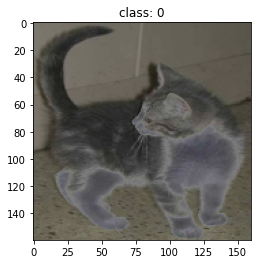

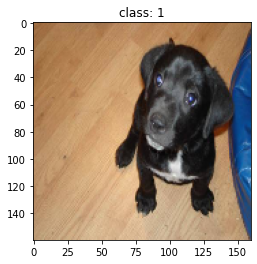

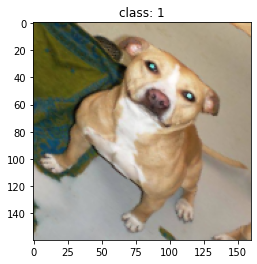

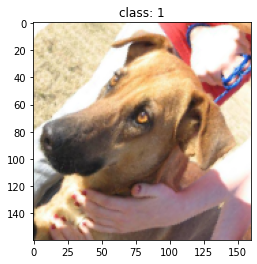

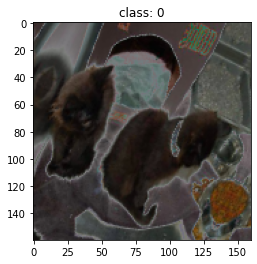

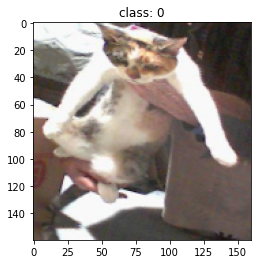

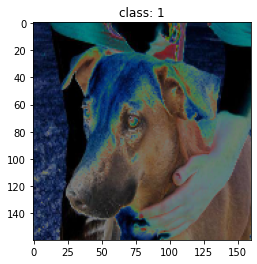

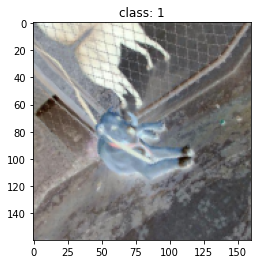

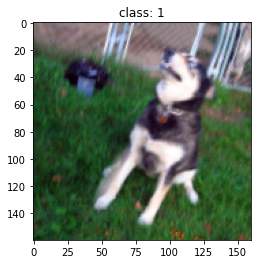

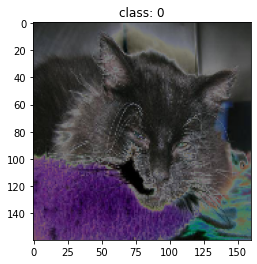

In [10]:
batch = next(iter(train_dataloader))
images, labels = batch[0], batch[1]
for i in range(10):
    a, label = images[i], labels[i]
    plt.imshow(a.permute(1, 2, 0))
    plt.title(f'class: {label.item()}')
    plt.show()

# 9. Define the Model

In [11]:
HIDDEN_DIM = 9216  

class SiamesetNet(nn.Module):
    def __init__(self):
        super(SiamesetNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(HIDDEN_DIM, 1024)
        self.fc2 = nn.Linear(1024, 300)
        self.dropout = nn.Dropout(0.3)

    def convs(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.bn5(self.conv5(x)))
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, HIDDEN_DIM)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x   # x -> (batch_size, 300)

### 9.1 Sanity check to see if model outputs are at right dimensions

In [12]:
model = SiamesetNet()
model.to(DEVICE)
tensor_img = torch.rand([16, 3, 160, 160])  # 16 images, 3 channels, 160, 160
output = model(tensor_img.to(DEVICE))
print(output.shape)  # 16 images, 300 dim each one

torch.Size([16, 300])


# 10. Train loop
Here we will use the pytorch miner lib that implement the online semihard mining strategy to select the triples that is not so easy to network neither so hard. You can read more about this at: https://kevinmusgrave.github.io/pytorch-metric-learning/

By the end of the training, you would get aroud 0.2 ~ 0.3 loss at last epochs.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_fn = losses.TripletMarginLoss(margin=2, distance=distance, reducer=reducer)
mining_fn = miners.TripletMarginMiner(margin=2, distance=distance, type_of_triplets="semihard")

for epoch in range(0, epochs):
    epoch_loss = []
    for data in tqdm(train_dataloader):
        img, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        optimizer.zero_grad()
        embeddings = model(img)
        indices_tuple = mining_fn(embeddings, labels)
        loss = loss_fn(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    print("Epoch {} - Loss {} - # Triplets {}".format(epoch, np.mean(epoch_loss), mining_fn.num_triplets))

    if epoch % 10 == 0:
        torch.save(model, ckpt_name)

torch.save(model, ckpt_name)

# 11. Predictions
Here we use the 5 cats and 5 dogs from the validation folder.

We run each picture against each other. When the pictures are from the same class, label = 1, otherwise 0.

You can see how good our siamese network score each pair of image.

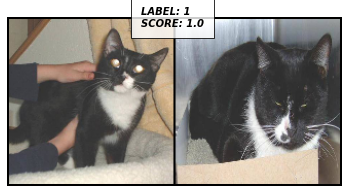

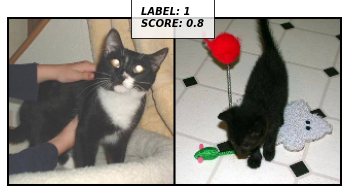

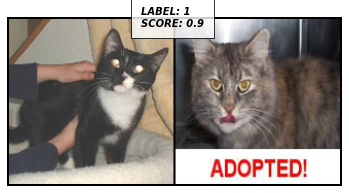

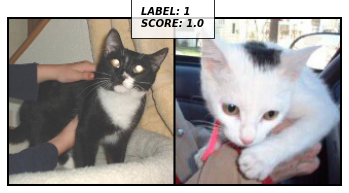

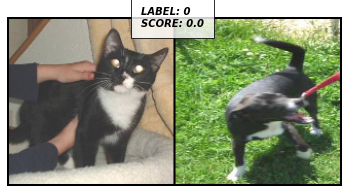

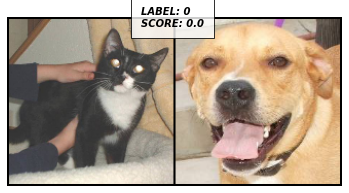

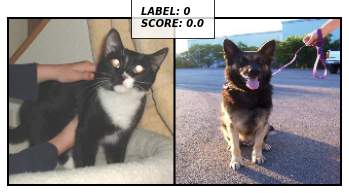

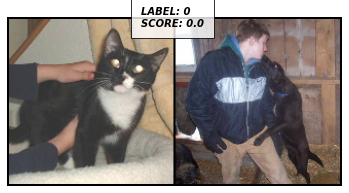

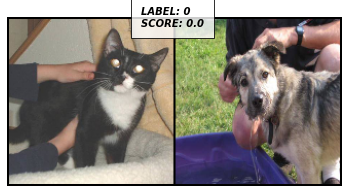

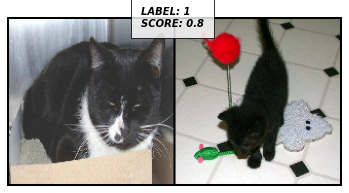

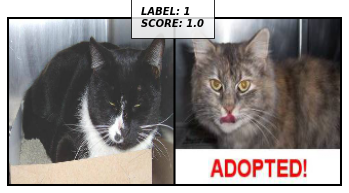

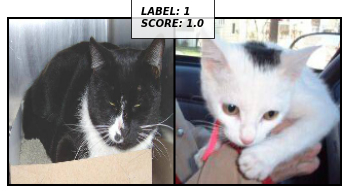

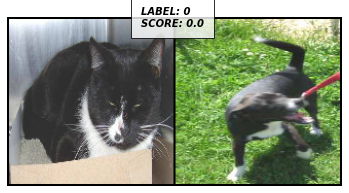

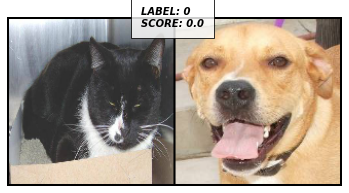

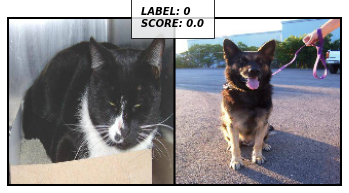

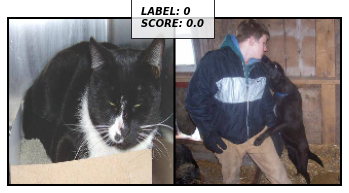

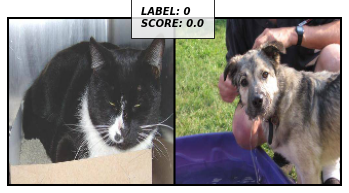

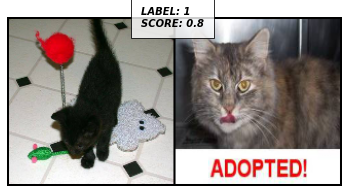

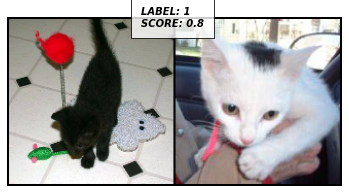

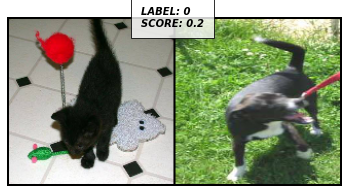

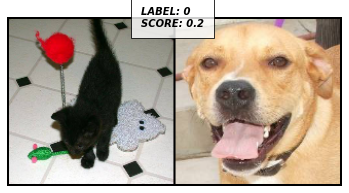

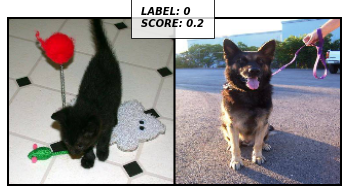

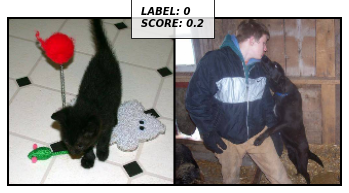

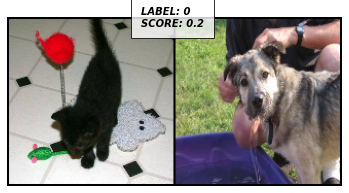

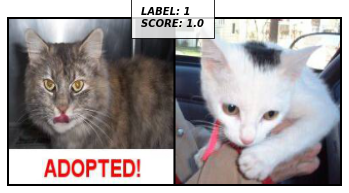

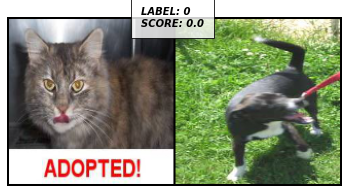

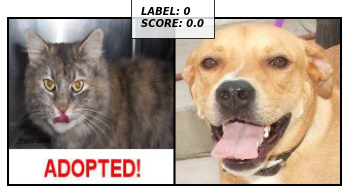

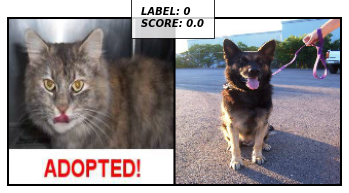

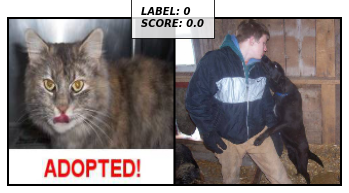

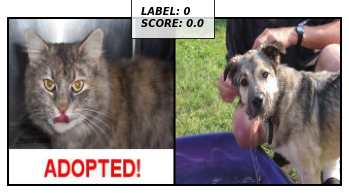

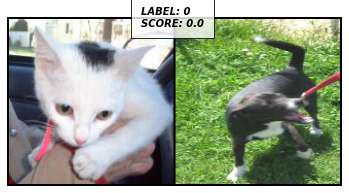

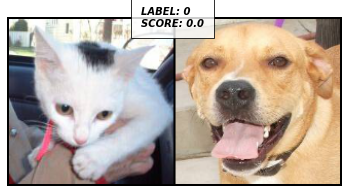

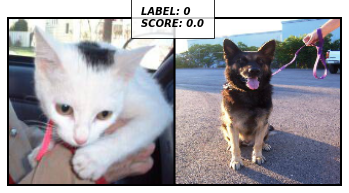

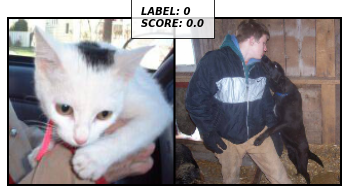

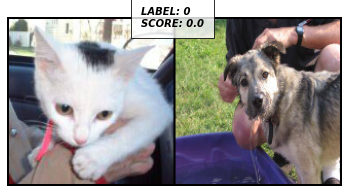

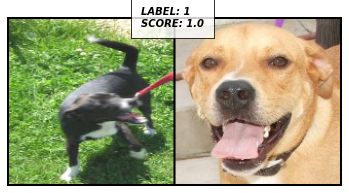

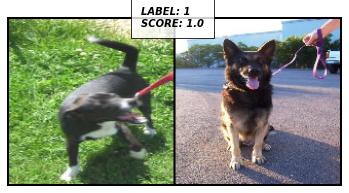

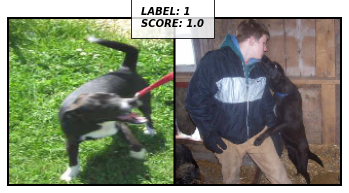

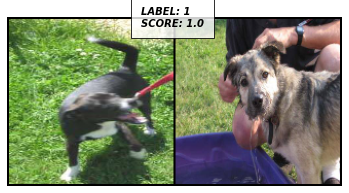

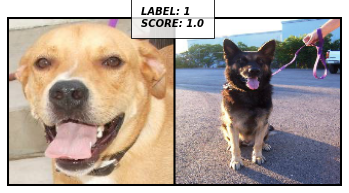

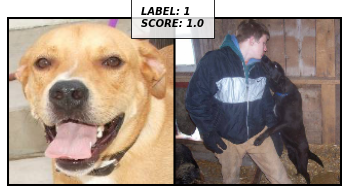

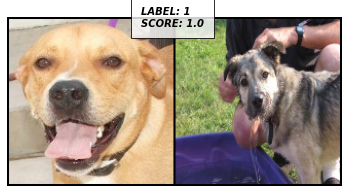

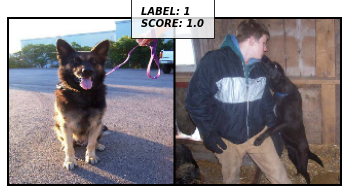

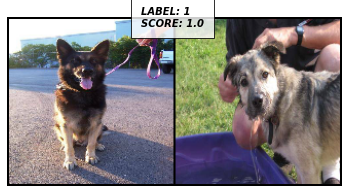

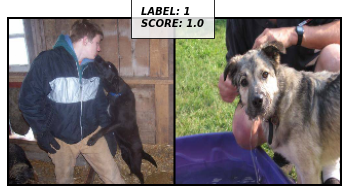

In [13]:
model = torch.load(ckpt_name, map_location=DEVICE)
model.eval()

val_folder = ImageFolder(root=val_dir)
val_dataset = SiameseDataset(val_folder, val_transform, validating=True)
val_dataloader_1 = DataLoader(val_dataset)

for i, img_tuple_1 in enumerate(val_dataloader_1):
    val_dataloader_2 = DataLoader(val_dataset)
    img_1 = img_tuple_1[0]
    label_1 = img_tuple_1[1]
    for j, img_tuple_2 in enumerate(val_dataloader_2):
        if j > i:
            img_2 = img_tuple_2[0]
            label_2 = img_tuple_2[1]
            concatenated = torch.cat((img_1, img_2), 0)

            with torch.no_grad():
                a = model(img_1.to(DEVICE))
                b = model(img_2.to(DEVICE))

            cosine = F.cosine_similarity(a, b)
            score = np.interp(cosine, (-1, 1), (0, 1))[0]

            label = (label_1 == label_2) * 1
            msg = f'LABEL: {label.item()}\nSCORE: {score:.1f}'
            imshow(torchvision.utils.make_grid(concatenated), msg)
    print()
    print()

# 12. Final words

What motivated me to write this notebook was the real problem I had to deal, and solved by using this implementation. Also, I see almost tutorial about this use the Ominiglot or MNIST dataset, where both are easily available in the PyTorch or TensorFlow libs.

As you probably saw, when dealing with pictures out of those common datasets, we have to implement a custom dataloader and provide some augumentations to "increase" our dataset.